# Evaluate Variation in Predictability over a Text

At some points in a text, it might not be possible to predict what words will
come next. At ther points, it might be possible to predict just the next word,
but not words beyond that. At yet other points, it might be possible to predict
multiple words into the future. This script quantifies this variability.

This script:
- Loads and tokenizes a text
- Runs a function called true_multistep_generate which uses GPT2 to process the text
  word-by-word, and at each word, predict n words (or rather, tokens) in the future.
  The function calculates metrics that evaluate the prediction at each step.
  The function currently predicts multiple words into the future using a greedy
  search approach in which a next word is predicted, then the top prediction is 
  treated as an "observed" word that is appended to the context and used to predict
  the next word, and so on. 
- Runs a function to align each word with its predictability metrics
- Plot predictability

Note: 
- Since this script uses a large language model, it is best run using a GPU
- For illustrative purposes, this script uses language input that has
  been artificially generated, which consists of several plausible sentences
  concatenated together (e.g., The man walked down the street looking for a coffee shop).
  The artificial input is short enough that it should be feasible to run this script
  quickly withut a GPU
- Your input should be in the form of a csv that contains at least one column called
  "word", where each row is a word. You may need some preprocessing to get to this point. 

Import dependencies (install if needed)

In [ ]:
# Optional: If you haven't already run pip install -r ../requirements.txt 
# to set up the environment, uncomment below to install requirements within 
# the notebook
# !pip install transformers torch pandas numpy matplotlib seaborn

In [17]:
try:
    from pathlib import Path
    import sys
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import torch
    from transformers import AutoModelForCausalLM, AutoTokenizer
except ImportError as e:
    raise ImportError("Required packages not found. Please run:\n\n    pip install -r ../requirements.txt\n") from e

In [5]:
# Add the scripts/ folder to Python’s module search path
script_path = Path("..") / "scripts"
sys.path.append(str(script_path))

# Now import functions from the scripts path
from true_multistep_generate import true_multistep_generate
from multistep_predictability import multistep_predictability

In [6]:
pd.set_option('display.max_columns', 20)

Next, set the paths for the input and output files

In [7]:
# Identify path to language_input folder and language input file.
# The language input file should be a .csv with at least one column called "word", and a row for each word.
# For simplicity, name your input file so that it first refers to the nature of the input, followed by _input. 

input_path = Path("..") / "language_input" / "artificial_test_input.csv"

# Set the location for output files

# Extract base name without "_input.csv"
base_name = input_path.stem.replace("_input", "")

# Define output directory and filename
output_dir = Path("..") / "predictability_output"
output_dir.mkdir(parents=True, exist_ok=True)

# Set file name for output of multistep predictions
output_filename = f"{base_name}_multistep_greedy.tsv"
output_path = output_dir / output_filename


# Set file name for output of multistep predictions
predictability_filename = f"{base_name}_multistep_greedy_predictability.tsv"
predictability_path = output_dir / predictability_filename

Next, load text input.

In [8]:
# Next, load text input

input_df = pd.read_csv(input_path)
assert "word" in input_df.columns, "input must contain a 'word' column"
input_df.head(10)

,word
0,The
1,man
2,walked
3,down
4,the
5,street
6,looking
7,for
8,a
9,coffee


Now, set parameters for multistep prediction.

The multistep prediction function will use GPT2 (Radford et al., 2019).

The function will use the HuggingFace transformers library to work with GPT2

Here, we will define arguments related to the model, including the model name,
context length, number of words to predict, and device (ideally use cuda to utilize GPU)

In [9]:
# Model name - keep as gpt2
modelname = "gpt2"

# Context length - can increase or decrease 
context_len = 32

# Number of upcoming words to predict. Note that n_predict = 1 is the same as just
# predicting the next word. As n_predict increases, we will predict more words into
# the future. 
n_predict = 3
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda", 0)
    print("Using cuda!")

Now, tokenize the input.

In [10]:
# Tokenize input with spacing preserved
tokenizer = AutoTokenizer.from_pretrained(modelname)

input_df.insert(0, "word_idx", input_df.index.values)
input_df["hftoken"] = input_df.word.apply(lambda x: tokenizer.tokenize(" " + x))

input_df = input_df[input_df["hftoken"].map(lambda x: len(x) > 0)]

input_df = input_df.explode("hftoken", ignore_index=True)
input_df["token_id"] = input_df.hftoken.apply(tokenizer.convert_tokens_to_ids)

input_df.head()

,word_idx,word,hftoken,token_id
0,0,The,ĠThe,383
1,1,man,Ġman,582
2,2,walked,Ġwalked,6807
3,3,down,Ġdown,866
4,4,the,Ġthe,262


Store the token ids

In [11]:
token_ids = input_df.token_id.tolist()

Run the multistep prediction function and store the output (this may take a while depending on length of input and use of GPU)

In [12]:
model = AutoModelForCausalLM.from_pretrained(modelname).to(device).eval()

output_df = true_multistep_generate(model, tokenizer, token_ids, context_len, input_df.copy(), n_predict=n_predict, device=device)

# Save the file
output_df.to_csv(output_path, sep="\t", index=False)

Align the predictability metrics to corresponding words.

Note that output_df is a dataframe where each row corresponds to a word in the input.
For each word, we have made predictions for multiple upcoming words (number was
specified in n_predict). We have also evaluated those predictions using some metrics,
including whether it matched the actual word that occurred at that step, the confidence
with which the word was predicted, and the rank of the actual word within the model's
predictions (rank closer to 1 = better prediction)

In [13]:
output_df.head(15)

,word_idx,word,hftoken,token_id,pred_token_t+1,pred_token_t+2,pred_token_t+3,pred_word_t+1,pred_word_t+2,pred_word_t+3,match_t+1,match_t+2,match_t+3,conf_t+1,conf_t+2,conf_t+3,rank_t+1,rank_t+2,rank_t+3
0,0,The,ĠThe,383,1708,318,257,following,is,a,0.0,0.0,0.0,0.195564,0.399910,0.707198,31.0,8728.0,924.0
1,1,man,Ġman,582,508,373,262,who,was,the,0.0,0.0,1.0,0.463277,0.404435,0.374889,93.0,1237.0,1.0
2,2,walked,Ġwalked,6807,1497,13,198,away,.,\n,0.0,0.0,0.0,0.655971,0.651765,0.533989,11.0,22.0,16813.0
3,3,down,Ġdown,866,262,4675,11,the,street,",",1.0,1.0,0.0,0.811531,0.626651,0.676821,1.0,1.0,9.0
4,4,the,Ġthe,262,4675,11,290,street,",",and,1.0,0.0,0.0,0.626651,0.676821,0.465820,1.0,9.0,157.0
5,5,street,Ġstreet,4675,11,290,262,",",and,the,0.0,0.0,0.0,0.676821,0.465820,0.468994,9.0,157.0,17.0
6,6,looking,Ġlooking,2045,329,257,1295,for,a,place,1.0,1.0,0.0,0.674543,0.612510,0.460912,1.0,1.0,124.0
7,7,for,Ġfor,329,257,1295,284,a,place,to,1.0,0.0,0.0,0.612510,0.460912,0.910061,1.0,124.0,1026.0
8,8,a,Ġa,257,1295,284,3993,place,to,sleep,0.0,0.0,0.0,0.460912,0.910061,0.619762,124.0,1026.0,10332.0
9,9,coffee,Ġcoffee,6891,6128,13,679,shop,.,He,1.0,0.0,0.0,0.730965,0.735600,0.589553,1.0,1710.0,13789.0


Now we want to quantify: for each actual word in the input, how well was it
predicted? And we want to quantify this for each step - e.g., how well was it predicted
1 word ago, 2 words ago, 3 words ago, etc.? 

Our dataframe already has this info, but it's not aligned to each word in this way. 
Currently, the rank, conf and match columns for each word refer to the predictions that 
were made *based on that word*. But instead, we want to know how well that word was 
*predicted by its preceding words*. 

The multistep_predictability function transforms output to accomplish this.
In the transformed output, each word will have n_predict rows (e.g., if we set
n_predict = 3, then each word will have 3 rows.) 

There is a "timestep" column that numbers these rows (e.g., if n_predict = 3, 
the timestep column for a word will have values 1, 2, 3)

Critically, there are two columns that denote the word's predictability for a given
timestep: pred_rank and pred_conf. These predictability columns indicate how predictable
a word was based on its preceding words. For example, for timestep = 1, the predctability
columns indicate a word's predictability based on the context words up to and including
the word 1 timestep ago (i.e., the immediately preceding word). For timestep = 2, 
these columns indicate a word's predicability based on the context words up to the word
2 timesteps ago (i.e., the word before last), and so on. 

In [14]:
multistep_df = multistep_predictability(output_df, n_predict)

# Save the file
multistep_df.to_csv(predictability_path, sep="\t", index=False)

# Look:
multistep_df.head(15)

,word_idx,word,hftoken,token_id,timestep,pred_token,pred_word,match,conf,rank,pred_rank,pred_conf
0,0,The,ĠThe,383,1,1708,following,0.0,0.195564,31.0,<NA>,<NA>
1,0,The,ĠThe,383,2,318,is,0.0,0.399910,8728.0,<NA>,<NA>
2,0,The,ĠThe,383,3,257,a,0.0,0.707198,924.0,<NA>,<NA>
3,1,man,Ġman,582,1,508,who,0.0,0.463277,93.0,31.0,0.195564
4,1,man,Ġman,582,2,373,was,0.0,0.404435,1237.0,<NA>,<NA>
5,1,man,Ġman,582,3,262,the,1.0,0.374889,1.0,<NA>,<NA>
6,2,walked,Ġwalked,6807,1,1497,away,0.0,0.655971,11.0,93.0,0.463277
7,2,walked,Ġwalked,6807,2,13,.,0.0,0.651765,22.0,8728.0,0.39991
8,2,walked,Ġwalked,6807,3,198,\n,0.0,0.533989,16813.0,<NA>,<NA>
9,3,down,Ġdown,866,1,262,the,1.0,0.811531,1.0,11.0,0.655971


Evaluate predictability. 

For each word, we can evaluate how predictable it was 1 word ago, 2 words ago, ... n_predict 
words ago.
To do this, we can examine the relationship between timestep (number of words ago) and 
pred_rank (the rank of the actual word within the model's predictions, where ranks closer to 
1 indicate higher predictability)

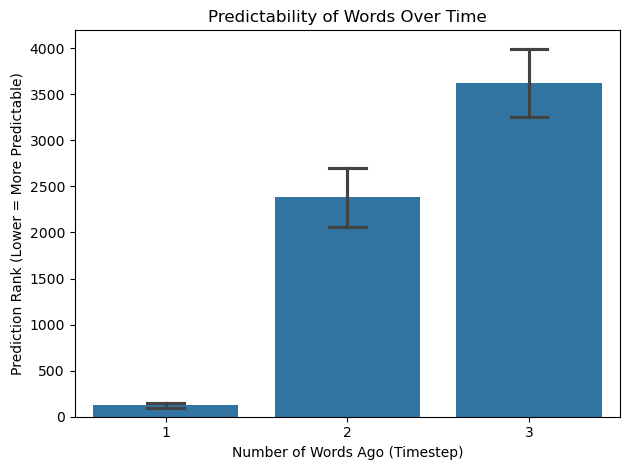

In [18]:
sns.barplot(data=multistep_df, x="timestep", y="pred_rank", errorbar=("se", 1), capsize=0.2)

# Customize axis titles
plt.xlabel("Number of Words Ago (Timestep)")
plt.ylabel("Prediction Rank (Lower = More Predictable)")
plt.title("Predictability of Words Over Time")

# Optional: improve layout
plt.tight_layout()
plt.show()